In [1]:
push!(LOAD_PATH,"../src")
import PDMP

In [2]:
using PyPlot
import Klara

In [3]:
using Distributions

# Multivariate Gaussian

1. 10dim Gaussian
2. 3dim Gaussian (compare SJV)
3. Truncated Gaussian
4. Univariate Gaussian



## MvG: Case 1 -- 10dim

In [4]:
srand(1235)
p   = 10
P1  = randn(p,p)
P1 *= P1'
mu  = zeros(p)

# DATA MODEL
mvg = PDMP.MvGaussianCanon(mu, P1)

# GEOMETRY
geom = PDMP.Unconstrained()
nextboundary(x, v) = PDMP.nextboundary(geom, x, v)

# GRADIENTS and IPPSampling
gll(x) = PDMP.gradloglik(mvg, x)
nextevent(x, v) = PDMP.nextevent_zz(mvg, x, v)

# SIMULATION

T, lref     = Inf, 1.
maxgradeval = 50000

x0  = mu       # initial point
v0  = ones(p)  # draw velocity
v0 /= norm(v0) # normalise velocity

sim = PDMP.Simulation(x0, v0, T, nextevent, gll, nextboundary, lref, "ZZ"; 
                        maxgradeval=maxgradeval)

(path, details) = PDMP.simulate(sim);

In [5]:
ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg  = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

println("MSE on mu:", norm(muest-mu)/p)

MSE on mu:0.04936458022267561


## Details about the simulation

Number of loops, bounces, gradient evaluation etc.

In [6]:
for kv in details
    println(kv)
end

Pair{String,Any}("nboundary",0)
Pair{String,Any}("nsegments",54585)
Pair{String,Any}("clocktime",1.5410571098327637)
Pair{String,Any}("nloops",54584)
Pair{String,Any}("nbounce",50000)
Pair{String,Any}("ngradeval",50000)
Pair{String,Any}("nrefresh",4584)


## Metrics

Takes a few minutes to load and compute 

In [7]:
ess = [Klara.ess([PDMP.samplepath(path,t)[i]
                for t in gg]) for i in 1:p]

esscpu = ess/details["clocktime"]

min_, mini_ = findmin(ess)
max_, maxi_ = findmax(ess)

println("Min ESS, dim$mini_ :: $(round(min_,2)) -- per CPUsec: $(round(esscpu[mini_],2))")
println("Max ESS, dim$maxi_ :: $(round(max_,2)) -- per CPUsec: $(round(esscpu[maxi_],2))")

Min ESS, dim2 :: 36.58 -- per CPUsec: 23.74
Max ESS, dim7 :: 134.62 -- per CPUsec: 87.36


## Boxplot of the ESS across dimensions

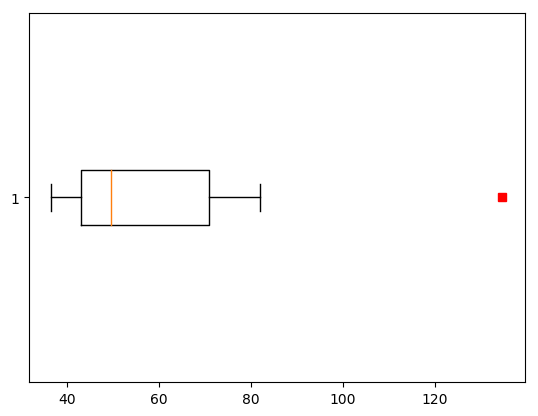

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => Any[PyObject <matplotlib.lines.Line2D object at 0x3202909d0>,Py…
  "fliers"   => Any[PyObject <matplotlib.lines.Line2D object at 0x32033d2d0>]
  "boxes"    => Any[PyObject <matplotlib.lines.Line2D object at 0x320321490>]
  "caps"     => Any[PyObject <matplotlib.lines.Line2D object at 0x320278f50>,Py…
  "medians"  => Any[PyObject <matplotlib.lines.Line2D object at 0x320321c50>]

In [8]:
boxplot(ess,0, "rs", 0)

## Visuals

### Picking dimensions, sampling the path appropriately and plotting

(this is quite quick for this simple model)

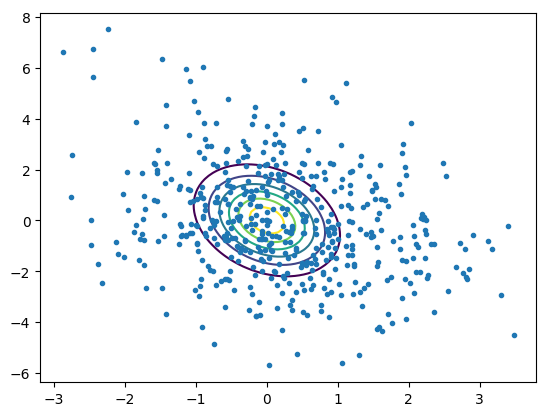

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320522150>

In [9]:
d1,  d2  = 3, 4

C1 = inv(P1)
C1s = C1[[d1,d2],[d1,d2]]

mu1, mu2 = mu[d1], mu[d2]
s1,  s2  = sqrt(C1[d1,d1]), sqrt(C1[d2,d2])
npts     = 250

x1min, x1max = mu1 + 2*[-s1,s1]
x2min, x2max = mu2 + 2*[-s2,s2]

ss = 500
Tp = path.ts[end] - 0.001 # FIXME (hack)
gt = linspace(0,Tp,ss)
xx = [PDMP.samplepath(path,t)[d1] for t in gt]
yy = [PDMP.samplepath(path,t)[d2] for t in gt];

# -----------------
# Building the grid

ng = 50 
x  = linspace(x1min, x1max, ng)
y  = linspace(x2min, x2max, ng)

xgrid = repmat(x', ng, 1)
ygrid = repmat(y, 1, ng)

z = zeros(ng,ng)
for i in 1:ng, j in 1:ng
    z[i,j] = exp(-dot([x[i],y[j]]-[mu1,mu2],inv(C1s)*([x[i],y[j]]-[mu1,mu2])))
end

# --------------
# Contour + path

contour(xgrid,ygrid,z)
plot(xx,yy, ".")

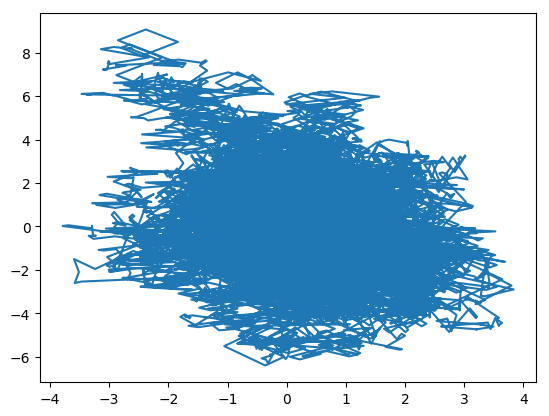

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328cd21d0>

In [15]:
plot(path.xs[d1,:], path.xs[d2,:])

## MvG: Case 2 -- comp SJV

In [10]:
T    = Inf
lref = 1.

srand(16) # Identical to Sebastian
p   = 3
P1  = randn(p,p)
P1 *= P1'
mu  = zeros(p)

mvg = PDMP.MvGaussianCanon(mu, P1)

geom = PDMP.Unconstrained()
nextboundary(x, v) = PDMP.nextboundary(geom, x, v)

gll(x) = PDMP.gradloglik(mvg, x)

nextevent(x, v) = PDMP.nextevent_zz(mvg, x, v)

v0  = randn(mvg.p)  # draw velocity
v0 /= norm(v0)      # normalise velocity
x0  = randn(p)      # initial point

sim = PDMP.Simulation(x0, v0, T, nextevent, gll,
                      nextboundary, lref, "ZZ"; maxgradeval=10000)

(path, details) = PDMP.simulate(sim);

In [11]:
ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg    = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

println("MSE on mu:", norm(muest-mu)/p)

MSE on mu:0.1955670750854914


In [18]:
for kv in details
    println(kv)
end

Pair{String,Any}("nboundary",0)
Pair{String,Any}("nsegments",17369)
Pair{String,Any}("clocktime",0.31546998023986816)
Pair{String,Any}("nloops",17368)
Pair{String,Any}("nbounce",10000)
Pair{String,Any}("ngradeval",10000)
Pair{String,Any}("nrefresh",7368)


In [12]:
ess = [Klara.ess([PDMP.samplepath(path,t)[i]
                for t in gg]) for i in 1:p]

esscpu = ess/details["clocktime"]

min_, mini_ = findmin(ess)
max_, maxi_ = findmax(ess)

println("Min ESS, dim$mini_ :: $(round(min_,2)) -- per CPUsec: $(round(esscpu[mini_],2))")
println("Max ESS, dim$maxi_ :: $(round(max_,2)) -- per CPUsec: $(round(esscpu[maxi_],2))")

Min ESS, dim3 :: 12.9 -- per CPUsec: 45.07
Max ESS, dim1 :: 16.98 -- per CPUsec: 59.32


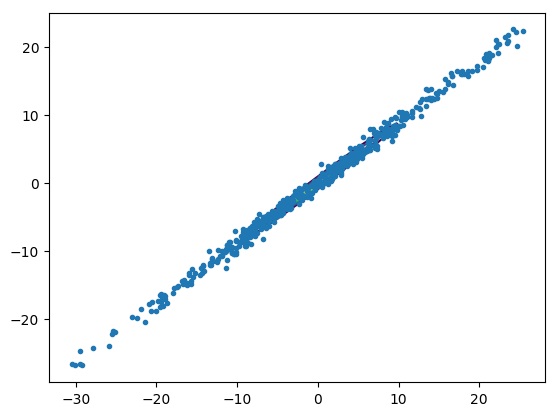

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324036390>

In [13]:
d1,  d2  = 2, 3

C1 = inv(P1)
C1s = C1[[d1,d2],[d1,d2]]

mu1, mu2 = mu[d1], mu[d2]
s1,  s2  = sqrt(C1[d1,d1]), sqrt(C1[d2,d2])
npts     = 250

x1min, x1max = mu1 + 2*[-s1,s1]
x2min, x2max = mu2 + 2*[-s2,s2]

ss = 500
Tp = path.ts[end] - 0.001 # FIXME (hack)
gt = linspace(0,Tp,ss)
xx = [PDMP.samplepath(path,t)[d1] for t in gt]
yy = [PDMP.samplepath(path,t)[d2] for t in gt];

# -----------------
# Building the grid

ng = 50 
x  = linspace(x1min, x1max, ng)
y  = linspace(x2min, x2max, ng)

xgrid = repmat(x', ng, 1)
ygrid = repmat(y, 1, ng)

z = zeros(ng,ng)
for i in 1:ng, j in 1:ng
    z[i,j] = exp(-dot([x[i],y[j]]-[mu1,mu2],inv(C1s)*([x[i],y[j]]-[mu1,mu2])))
end

# --------------
# Contour + path

contour(xgrid,ygrid,z)
plot(xx,yy, ".")

## MvG: Case 3 -- truncated gaussian

In [20]:
srand(234)
p   = 2
P1  = randn(p,p)
P1 *= P1'
mu  = zeros(p)+1.
C1  = inv(P1)
C1 += C1'
C1 /= 2

sN  = 10000
spl = rand(MvNormal(C1),sN)
for i in 1:p
    spl[i,:] += mu[i]
end

splp_m = zeros(2)
np     = 0
for i in 1:sN
    if !any(e->e<0, spl[:,i])
        splp_m += spl[:,i]
        np     += 1
    end
end
trunc_mean = splp_m / np




2-element Array{Float64,1}:
 1.34427 
 0.936328

In [21]:
T    = 1000.0
lref = 2.

srand(234)
p   = 2
P1  = randn(p,p)
P1 *= P1'
mu  = zeros(p)+1.

# DATA MODEL
mvg = PDMP.MvGaussianCanon(mu, P1)

# GEOMETRY
ns, a = eye(p), zeros(p)
geom  = PDMP.Polygonal(ns,a)
nextboundary(x,v) = PDMP.nextboundary(geom, x, v)

# GRADIENTS + IPP sampler
gll(x) = PDMP.gradloglik(mvg, x)
nextevent(x, v) = PDMP.nextevent_zz(mvg, x, v)

# Simulation
x0  = mu            # initial point
v0  = randn(mvg.p)  # draw velocity
v0 /= norm(v0)      # normalise velocity

sim = PDMP.Simulation(x0, v0, T, nextevent, gll,nextboundary, lref, "ZZ";
                        maxgradeval=10000)

(path, details) = PDMP.simulate(sim);

In [22]:
ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg  = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

2-element Array{Float64,1}:
 1.45221 
 0.919172

In [23]:
trunc_mean

2-element Array{Float64,1}:
 1.34427 
 0.936328

In [24]:
println("rel error: ", norm(muest-trunc_mean)/norm(trunc_mean))

rel error: 0.06671736398179084


In [25]:
for kv in details
    println(kv)
end

Pair{String,Any}("nboundary",345)
Pair{String,Any}("nsegments",3352)
Pair{String,Any}("clocktime",0.1395740509033203)
Pair{String,Any}("nloops",3351)
Pair{String,Any}("nbounce",952)
Pair{String,Any}("ngradeval",952)
Pair{String,Any}("nrefresh",2054)


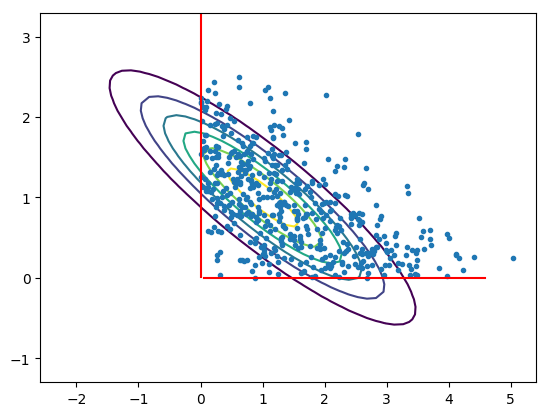

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325b6f810>

In [26]:
d1,  d2  = 1, 2
C1 = inv(P1)
C1s = C1[[d1,d2],[d1,d2]]

mu1, mu2 = mu[d1], mu[d2]
s1,  s2  = sqrt(C1[d1,d1]), sqrt(C1[d2,d2])
npts     = 250

x1min, x1max = mu1 + 2*[-s1,s1]
x2min, x2max = mu2 + 2*[-s2,s2]

ss = 500
Tp = path.ts[end] - 0.001 # FIXME (hack)
gt = linspace(0,Tp,ss)
xx = [PDMP.samplepath(path,t)[d1] for t in gt]
yy = [PDMP.samplepath(path,t)[d2] for t in gt];

# -----------------
# Building the grid

ng = 50 
x  = linspace(x1min, x1max, ng)
y  = linspace(x2min, x2max, ng)

xgrid = repmat(x', ng, 1)
ygrid = repmat(y, 1, ng)

z = zeros(ng,ng)
for i in 1:ng, j in 1:ng
    z[i,j] = exp(-dot([x[i],y[j]]-[mu1,mu2],inv(C1s)*([x[i],y[j]]-[mu1,mu2])))
end

# --------------
# Contour + path

contour(xgrid,ygrid,z)
plot(xx,yy, ".")

plot(x[x.>0], x[x.>0]*0, "-r")
plot(y[y.>0]*0, y[y.>0], "-r" )

## Univariate Gaussian

In [27]:
T    = Inf
lref = 2.
maxgradeval = 50000

srand(1235)
p   = 1
P1  = eye(p)#randn(p,p)
P1 *= P1'
mu  = zeros(p)

mvg = PDMP.MvGaussianCanon(mu, P1)

# Geometry
geom = PDMP.Unconstrained()
nextboundary(x, v) = PDMP.nextboundary(geom, x, v)

# Grad Log Lik (not subsampled)
gll(x) = PDMP.gradloglik(mvg, x)

# Next event (using exact sampling since gaussian)
nextevent(x, v) = PDMP.nextevent_zz(mvg, x, v)

# Initialisation
x0  = mu            # initial point
v0  = randn(mvg.p)  # draw velocity
v0 /= norm(v0)      # normalise velocity

sim = PDMP.Simulation( x0, v0, T, nextevent, gll,
                       nextboundary, lref, "ZZ"; maxgradeval=maxgradeval)

(path, details) = PDMP.simulate(sim)

for kv in details
    println(kv)
end

ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg    = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

println("MSE on mu:", norm(muest-mu)/p)

Pair{String,Any}("nboundary",0)
Pair{String,Any}("nsegments",365769)
Pair{String,Any}("clocktime",4.653154134750366)
Pair{String,Any}("nloops",365768)
Pair{String,Any}("nbounce",50000)
Pair{String,Any}("ngradeval",50000)
Pair{String,Any}("nrefresh",315768)
MSE on mu:0.0010918686996180813


In [28]:
ess = Klara.ess([PDMP.samplepath(path,t)[1] for t in gg])

9947.603344021454

In [29]:
ess/details["clocktime"]

2137.8194351507605

In [30]:
ss = 1000
Tp = path.ts[end] - 0.001 # FIXME (hack)
gt = linspace(0,Tp,ss)
xx = [PDMP.samplepath(path,t)[1] for t in gt];

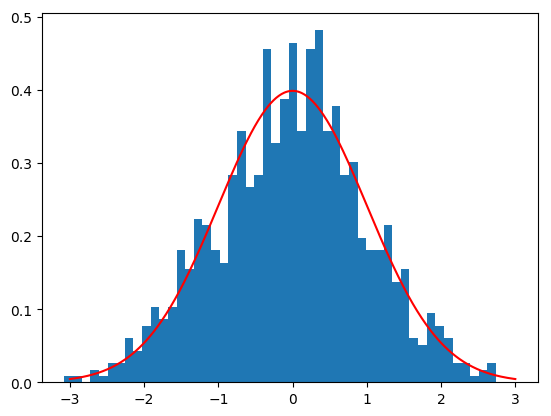

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3201b8a10>

In [31]:
PyPlot.plt[:hist](xx,50,normed=true)

xl = linspace(-3,3,500)
yl = exp(-1./2*(xl-mu[1]).^2*P1[1,1])/sqrt(2*pi)*P1[1,1]

plot(xl,yl,"-r")